In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import linear_sum_assignment
from scipy.stats import kendalltau

from boa.core.utils import inv_perm
from boa.core.distribution import GumbelMatching

from boa.models.gpar import GPARModel
from boa.models.gpar_perm import PermutedGPARModel
from boa.models.fully_factorized_gp import FullyFactorizedGPModel

from stheno.tensorflow import GP

from itertools import permutations

plot_directory = "../plots/notebook_plots/GS-GPAR/"

In [2]:
tf.config.experimental.set_visible_devices([], 'GPU')

In [3]:
def toy_y(xs):
    """
    Toy dataset from the GPAR paper
    """
    
    xs = xs.reshape((-1, 1))
    
    def y1(x, eps_loc=0., eps_scale=0.05):
        
        eps = np.random.normal(loc=eps_loc, scale=eps_scale, size=x.shape)
        
        return -np.sin(10 * np.pi * (x + 1)) / (2 * x + 1) - x**4 + eps
    
    
    def y2(x, eps_loc=0., eps_scale=0.05):
        
        eps = np.random.normal(loc=eps_loc, scale=eps_scale, size=x.shape)
        
        return np.cos(y1(x))**2 + np.sin(3 * x) + eps
    
    
    def y3(x, eps_loc=0., eps_scale=0.05):
        
        eps = np.random.normal(loc=eps_loc, scale=eps_scale, size=x.shape)
        
        return y2(x) * y1(x)**2 + 3 * x + eps
    
    
    return np.concatenate([y1(xs), y2(xs), y3(xs)], axis=1)

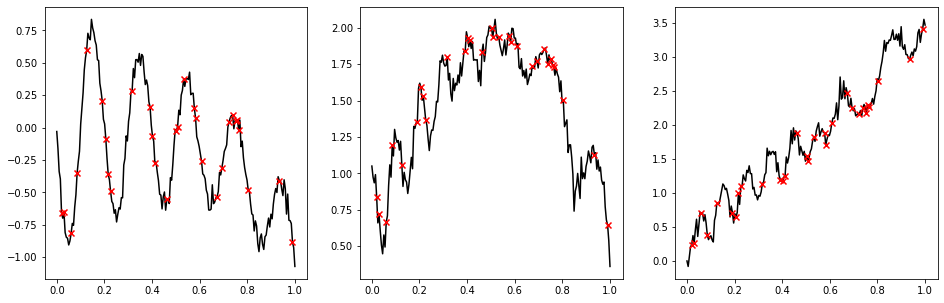

In [4]:
np.random.seed(40)

num_points = 200

xs = np.linspace(0, 1, num_points)

ys = toy_y(xs)

plt.figure(figsize=(16, 5))

train_and_validate_indices = np.random.choice(num_points, 50, replace=False) 

train_indices = train_and_validate_indices[:30]
valid_indices = train_and_validate_indices[30:]

for i in range(3):
    plt.subplot(int(f"13{i + 1}"))
    plt.plot(xs, ys[:, i], color='k', zorder=-1)
    plt.scatter(xs[train_indices], ys[train_indices, i], color='r', marker='x')

In [214]:
n = 4

gm = GumbelMatching(tf.zeros((n, n), dtype=tf.float64))

In [215]:
p1 = gm.sample(as_tuple=True)
p2 = gm.sample(as_tuple=True)
p1, p2

((0, 1, 2, 3), (3, 0, 1, 2))

# Test the effects of various permutations of the outputs on the performance of the fully factorized GP model and GPAR

In [7]:
perms = list(permutations(range(3)))

gps = {}

gp_input = xs[train_indices].reshape((-1, 1))
gp_output = ys[train_indices]

ff_gp = FullyFactorizedGPModel(kernel="rbf", input_dim=1, output_dim=3, initialization_heuristic="random")
ff_gp = ff_gp.condition_on(gp_input, gp_output)
ff_gp.fit_to_conditioning_data(optimizer_restarts=3)

for perm in perms[:]:
    
    gp_input = xs[train_indices].reshape((-1, 1))
    gp_output = ys[train_indices]
    gp_output = gp_output[:, perm]

    gpar = GPARModel(kernel="rbf", input_dim=1, output_dim=3, initialization_heuristic="median")
    gpar = gpar.condition_on(gp_input, gp_output)
    
    p_gpar = PermutedGPARModel(kernel="rbf", input_dim=1, output_dim=3, initialization_heuristic="median")
    p_gpar = p_gpar.condition_on(gp_input, gp_output)
    
    gpar.fit_to_conditioning_data(optimizer_restarts=1)
    p_gpar.fit_to_conditioning_data(optimizer_restarts=1, 
                                    learn_rate=1e-1, 
                                    tolerance=1e-5,
                                    start_temp=1.,
                                    end_temp=0.1,
                                    hard_forward_permutation=True,
                                    beta=3.)
    
    gps[perm] = {}
    gps[perm]["gpar"] = gpar
    gps[perm]["ff_gp"] = ff_gp
    gps[perm]["p_gpar"] = p_gpar

06/03/2020 03:50:22 PM:INFO:boa.models.fully_factorized_gp:Training data supplied with xs shape (30, 1) and ys shape (30, 3), training!
INFO:boa.models.fully_factorized_gp:Training data supplied with xs shape (30, 1) and ys shape (30, 3), training!
06/03/2020 03:50:22 PM:INFO:boa.models.fully_factorized_gp:Dimension 0 Optimization round: 1 / 3
INFO:boa.models.fully_factorized_gp:Dimension 0 Optimization round: 1 / 3
06/03/2020 03:50:24 PM:INFO:boa.models.fully_factorized_gp:New best objective value for dimension 0: 21.1187
INFO:boa.models.fully_factorized_gp:New best objective value for dimension 0: 21.1187
06/03/2020 03:50:24 PM:INFO:boa.models.fully_factorized_gp:Dimension 0 Optimization round: 2 / 3
INFO:boa.models.fully_factorized_gp:Dimension 0 Optimization round: 2 / 3
06/03/2020 03:50:25 PM:INFO:boa.models.fully_factorized_gp:Loss for dimension 0: 21.1187
INFO:boa.models.fully_factorized_gp:Loss for dimension 0: 21.1187
06/03/2020 03:50:25 PM:INFO:boa.models.fully_factorized_gp:

INFO:boa.models.gpar_perm:Output 2, Iteration 1: New best loss: -4.052
06/03/2020 03:55:31 PM:INFO:boa.models.gpar:Training data supplied with xs shape (30, 1) and ys shape (30, 3), training!
INFO:boa.models.gpar:Training data supplied with xs shape (30, 1) and ys shape (30, 3), training!
06/03/2020 03:55:31 PM:INFO:boa.models.gpar:Output 0, Iteration 1: New best loss: 5.525
INFO:boa.models.gpar:Output 0, Iteration 1: New best loss: 5.525
06/03/2020 03:55:32 PM:INFO:boa.models.gpar:Output 1, Iteration 1: New best loss: 19.388
INFO:boa.models.gpar:Output 1, Iteration 1: New best loss: 19.388
06/03/2020 03:55:33 PM:INFO:boa.models.gpar:Output 2, Iteration 1: New best loss: 4.219
INFO:boa.models.gpar:Output 2, Iteration 1: New best loss: 4.219
06/03/2020 03:55:33 PM:INFO:boa.models.gpar_perm:Training data supplied with xs shape (30, 1) and ys shape (30, 3), training!
INFO:boa.models.gpar_perm:Training data supplied with xs shape (30, 1) and ys shape (30, 3), training!
Loss at iteration 99

06/03/2020 03:59:43 PM:INFO:boa.models.gpar:GPs haven't been cached yet, creating them now.
INFO:boa.models.gpar:GPs haven't been cached yet, creating them now.
06/03/2020 03:59:44 PM:INFO:boa.models.gpar_perm:GPs haven't been cached yet, creating them now.
INFO:boa.models.gpar_perm:GPs haven't been cached yet, creating them now.
06/03/2020 03:59:44 PM:INFO:boa.models.fully_factorized_gp:GPs haven't been cached yet, creating them now.
INFO:boa.models.fully_factorized_gp:GPs haven't been cached yet, creating them now.


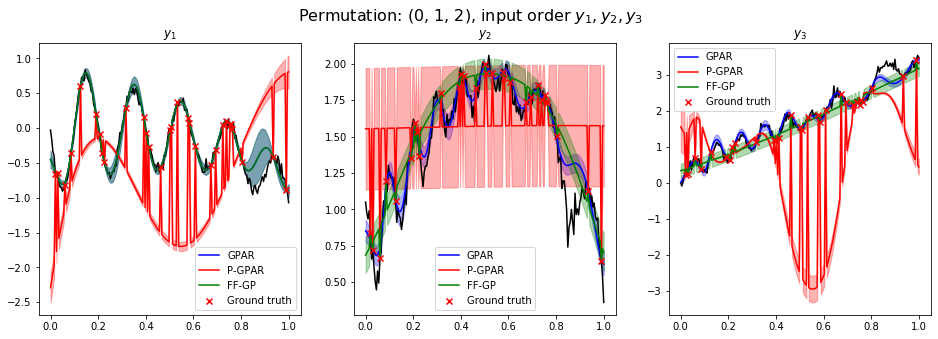

06/03/2020 03:59:45 PM:INFO:boa.models.gpar:GPs haven't been cached yet, creating them now.
INFO:boa.models.gpar:GPs haven't been cached yet, creating them now.
06/03/2020 03:59:45 PM:INFO:boa.models.gpar_perm:GPs haven't been cached yet, creating them now.
INFO:boa.models.gpar_perm:GPs haven't been cached yet, creating them now.


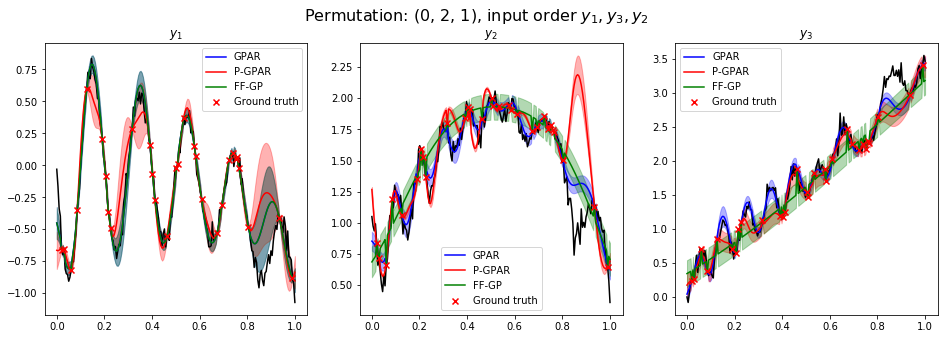

06/03/2020 03:59:46 PM:INFO:boa.models.gpar:GPs haven't been cached yet, creating them now.
INFO:boa.models.gpar:GPs haven't been cached yet, creating them now.
06/03/2020 03:59:46 PM:INFO:boa.models.gpar_perm:GPs haven't been cached yet, creating them now.
INFO:boa.models.gpar_perm:GPs haven't been cached yet, creating them now.


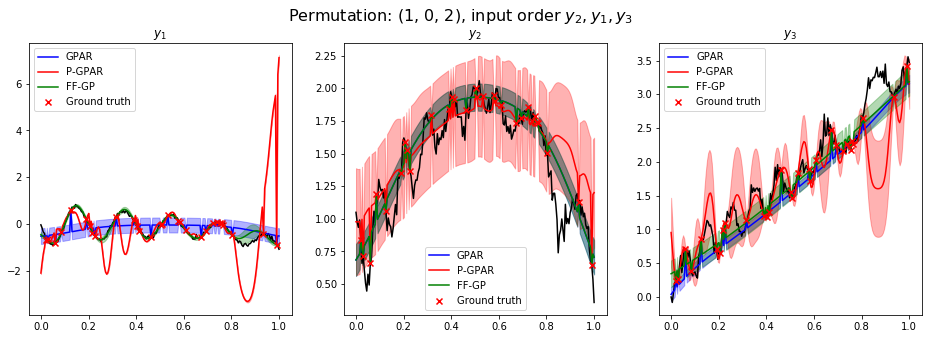

06/03/2020 03:59:47 PM:INFO:boa.models.gpar:GPs haven't been cached yet, creating them now.
INFO:boa.models.gpar:GPs haven't been cached yet, creating them now.
06/03/2020 03:59:47 PM:INFO:boa.models.gpar_perm:GPs haven't been cached yet, creating them now.
INFO:boa.models.gpar_perm:GPs haven't been cached yet, creating them now.


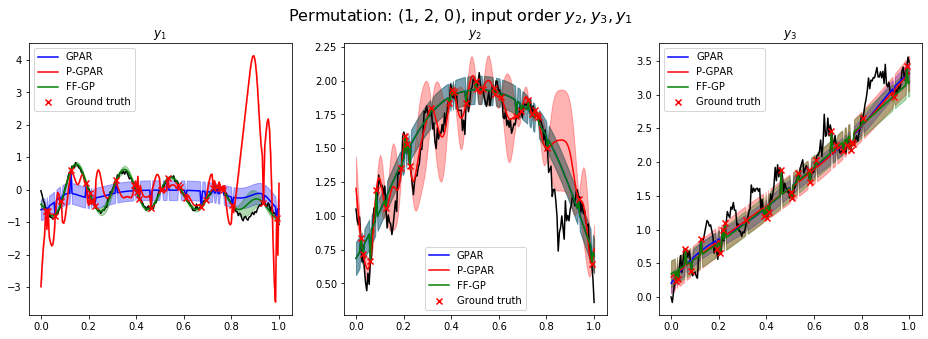

06/03/2020 03:59:48 PM:INFO:boa.models.gpar:GPs haven't been cached yet, creating them now.
INFO:boa.models.gpar:GPs haven't been cached yet, creating them now.
06/03/2020 03:59:48 PM:INFO:boa.models.gpar_perm:GPs haven't been cached yet, creating them now.
INFO:boa.models.gpar_perm:GPs haven't been cached yet, creating them now.


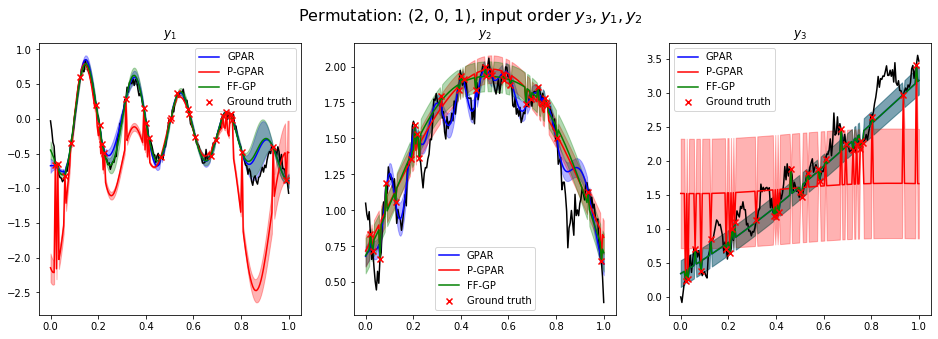

06/03/2020 03:59:48 PM:INFO:boa.models.gpar:GPs haven't been cached yet, creating them now.
INFO:boa.models.gpar:GPs haven't been cached yet, creating them now.
06/03/2020 03:59:48 PM:INFO:boa.models.gpar_perm:GPs haven't been cached yet, creating them now.
INFO:boa.models.gpar_perm:GPs haven't been cached yet, creating them now.


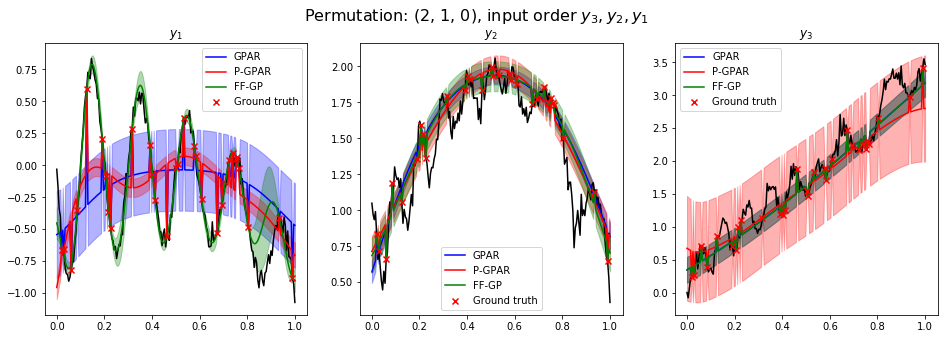

In [8]:
for k, v in gps.items():
    
    gpar = v["gpar"]
    ff_gp = v["ff_gp"]
    p_gpar = v["p_gpar"]
    
    print(v["p_gpar"])

    means, var = gpar.predict(xs.reshape((-1, 1)), numpy=True)
    p_means, p_var = p_gpar.predict(xs.reshape((-1, 1)), numpy=True)
    means_, var_ = ff_gp.predict(xs.reshape((-1, 1)), numpy=True)
    
    k_inv = inv_perm(k)

    plt.figure(figsize=(16, 5))
    plt.suptitle(f"Permutation: {k}, input order $y_{k[0] + 1}, y_{k[1] + 1}, y_{k[2] + 1}$", fontsize=16)

    for i in k_inv:
        plt.subplot(int(f"13{k[i] + 1}"))
        plt.title(f"$y_{k[i] + 1}$")

        plt.plot(xs, ys[:, k[i]], color='k')

        # GPAR
        plt.plot(xs, means[:, i], color='blue', label="GPAR")
        plt.fill_between(xs, 
                         (means[:, i] + np.sqrt(var[:, i])).T, 
                         (means[:, i] - np.sqrt(var[:, i])).T,
                         color='blue',
                         alpha=0.3,
                         zorder=-1)
        
        # P-GPAR
        plt.plot(xs, p_means[:, i], color='red', label="P-GPAR")
        plt.fill_between(xs, 
                         (p_means[:, i] + np.sqrt(p_var[:, i])).T, 
                         (p_means[:, i] - np.sqrt(p_var[:, i])).T,
                         color='red',
                         alpha=0.3,
                         zorder=-1)
        # FF-GP
        plt.plot(xs, means_[:, k[i]], color='green', label="FF-GP")
        plt.fill_between(xs, 
                         (means_[:, k[i]] + np.sqrt(var_[:, k[i]])).T, 
                         (means_[:, k[i]] - np.sqrt(var_[:, k[i]])).T,
                         color='green',
                         alpha=0.3,
                         zorder=-1)
        
        plt.scatter(xs[train_indices], 
                    ys[train_indices, k[i]], 
                    color='r', 
                    marker='x', 
                    label="Ground truth",
                    zorder=10)
    
        plt.legend()
    
    plt.savefig(plot_directory + f"/hard_perm/perm_{k[0]}_{k[1]}_{k[2]}.png")
    plt.show()

In [13]:
# Soft perm

for k, v in gps.items():
    print(f"{k}\ninverse: {inv_perm(k)}")

    print(f"Inverse learnt: {tf.argmax(v['p_gpar'].permutation, axis=1).numpy()}")
    #print(v["p_gpar"].soft_perm.numpy())
    #print(-tf.reduce_sum(v["p_gpar"].soft_perm * tf.math.log(v["p_gpar"].soft_perm)))

(0, 1, 2)
inverse: [0 1 2]
Inverse learnt: [1 0 2]
(0, 2, 1)
inverse: [0 2 1]
Inverse learnt: [0 1 2]
(1, 0, 2)
inverse: [1 0 2]
Inverse learnt: [1 2 0]
(1, 2, 0)
inverse: [2 0 1]
Inverse learnt: [1 0 2]
(2, 0, 1)
inverse: [1 2 0]
Inverse learnt: [1 2 0]
(2, 1, 0)
inverse: [2 1 0]
Inverse learnt: [2 0 1]


In [16]:
for k, v in gps.items():
    print(v["gpar"].log_prob(xs.reshape((-1, 1)), ys[:, k]))

tf.Tensor(1334.2685749663735, shape=(), dtype=float64)
tf.Tensor(1327.0830150342338, shape=(), dtype=float64)
tf.Tensor(747.8388288066526, shape=(), dtype=float64)
tf.Tensor(834.131084758309, shape=(), dtype=float64)
tf.Tensor(929.6783561540606, shape=(), dtype=float64)
tf.Tensor(728.0224074577151, shape=(), dtype=float64)


In [45]:
gps[(0, 1, 2)]["p_gpar"].signal_amplitudes[0].assign([.3])
gps[(0, 1, 2)]["p_gpar"].models=[]

In [44]:
gps[(0, 1, 2)]["p_gpar"].length_scales[0].assign([0.001])

<tf.Variable 'UnreadVariable' shape=(1,) dtype=float64, numpy=array([0.001])>

In [35]:
# Hard perm

for k, v in gps.items():
    print(k)
    print(v["p_gpar"].permutation.numpy())
    print(v["p_gpar"].soft_perm.numpy())

(0, 1, 2)
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]
[[1.06084681e-07 9.99999261e-01 8.72356652e-07]
 [2.77711097e-05 3.38780080e-07 9.99994101e-01]
 [9.99972123e-01 4.00123949e-07 5.02705467e-06]]


tf.Tensor([1.], shape=(1,), dtype=float64)


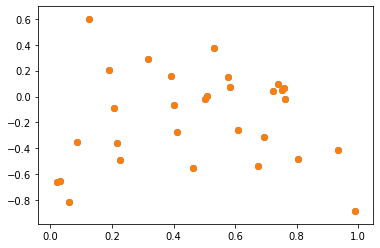

In [74]:
gp_ = gps[(0, 1, 2)]["gpar"].models[0]
print(gp_.noise_amplitude)
gp_.noise_amplitude = tf.constant([10.], dtype=tf.float64)
pred_ys, _ = (gp_ | (xs[train_indices, None], ys[train_indices, :1])).predict(xs[train_indices, None])

plt.scatter(xs[train_indices], pred_ys)
plt.scatter(xs[train_indices], ys[train_indices, 0])

# Gumbel-Softmax on MNIST

In [16]:
# Create dataset
batch_size = 64

data_path = "../../../../scratch/gf332/BayesOpt/data/mnist/mnist.npz"

(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data(path=data_path)

dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = dataset.map(lambda x: tf.cast(x, tf.float32) / 255.)
dataset = dataset.shuffle(5000)
dataset = dataset.repeat()
dataset = dataset.batch(batch_size)

In [25]:
class GumbelSoftmax(tf.Module):
    
    def __init__(self, log_probs, name="gumbel_softmax", **kwargs):
        
        super(GumbelSoftmax, self).__init__(name=name, **kwargs)
        
        log_probs = tf.convert_to_tensor(log_probs, dtype=tf.float32)
        
        # ensure that the log-probs are one dimensional
        if len(log_probs.shape) != 1:
            raise Exception("log probabilities must be a 1-d vector!")
        
        self.log_probs = log_probs
    
    def _sample_gumbel_0_1(self, shape, eps=1e-20):
                 
        u = tf.random.uniform(minval=0., maxval=1., shape=shape, dtype=tf.float32)
        
        return -tf.math.log(-tf.math.log(u + eps))
    
    def sample(self, shape=None):
        
        if shape is None:
            shape = self.log_probs.shape
            
        else:
            shape = shape + self.log_probs.shape
            
        
        eps = self._sample_gumbel_0_1(shape)
        
        shape = shape[:-1]
        
        log_probs = tf.reshape(self.log_probs, [1] * len(shape) + [-1])
        
        log_probs = tf.tile(log_probs, shape + (1,))
        
        perturbed = log_probs + eps
        
        return perturbed

In [26]:
gs = GumbelSoftmax([1, 2, 3])

# Sinkhorn-reparametrized permutation

In [147]:
perm = PermutationVariable(n_items=5, temperature=0.3)
perm.permute(np.arange(5), soft=False)

<tf.Tensor: id=4674027, shape=(5, 1), dtype=float64, numpy=
array([[2.],
       [1.],
       [0.],
       [3.],
       [4.]])>

In [98]:
pm = perm.permutation_matrix()

# Learn the permutation matrix

In [31]:
def permutation_matrix(perm_mat, temperature, sinkhorn_iterations=10, soft=True):
    
    if perm_mat.dtype != tf.float64:
        raise Exception("Dtype of perm_mat must be tf.float64")

    # Add Gumbel noise for robustness
    perm_mat = perm_mat - tf.math.log(-tf.math.log(tf.random.uniform(shape=perm_mat.shape,
                                                                     dtype=tf.float64) + 1e-20))

    perm_mat = perm_mat / temperature

    # Perform Sinkhorn normalization
    for _ in range(sinkhorn_iterations):

        # Column-wise normalization in log domain
        perm_mat = perm_mat - tf.reduce_logsumexp(perm_mat, axis=1, keepdims=True)

        # Row-wise normalization in log domain
        perm_mat = perm_mat - tf.reduce_logsumexp(perm_mat, axis=0, keepdims=True)

    perm_mat = tf.exp(perm_mat)

    if not soft:
        perm_mat = tf.one_hot(tf.argmax(perm_mat, axis=0), self.n_items, dtype=self.dtype)

    return perm_mat

In [34]:
tf.random.set_seed(42)

perm_mat = tf.Variable(tf.random.uniform(shape=(3,3), dtype=tf.float64))

permutation_matrix(perm_mat, 1)

<tf.Tensor: id=3461716, shape=(3, 3), dtype=float64, numpy=
array([[0.09316717, 0.15851558, 0.74835093],
       [0.25733257, 0.66493325, 0.07771331],
       [0.64950026, 0.17655117, 0.17393576]])>

In [5]:
p_gpar = PermutedGPARModel(kernel="rbf", input_dim=1, output_dim=3, initialization_heuristic="median")
p_gpar = p_gpar.condition_on(xs[train_indices, None], ys[train_indices, :])

In [6]:
hps = p_gpar.initialize_hyperparameters(length_scale_init="random")

perm, _, _, _ = hps

In [21]:
p = p_gpar.permutation_matrix(perm, temperature=1e-10, sinkhorn_iterations=100)
p

(<tf.Tensor: shape=(3, 3), dtype=float64, numpy=
 array([[0.02050161, 0.27443474, 0.70506365],
        [0.70526869, 0.09642056, 0.19831075],
        [0.2742297 , 0.62914471, 0.09662559]])>,
 <tf.Tensor: shape=(3, 3), dtype=float64, numpy=
 array([[0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.]])>)

In [22]:
print(tf.reduce_sum(p, axis=1))
print(tf.reduce_sum(p, axis=0))

tf.Tensor(
[[1. 1. 1.]
 [1. 1. 1.]], shape=(2, 3), dtype=float64)
tf.Tensor(
[[0.02050161 1.27443474 0.70506365]
 [0.70526869 0.09642056 1.19831075]
 [1.2742297  0.62914471 0.09662559]], shape=(3, 3), dtype=float64)


In [23]:
tf.matmul(p[1], tf.transpose(p[1]))

<tf.Tensor: shape=(3, 3), dtype=float64, numpy=
array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])>

In [24]:
tf.matmul(p[1], p[1])

<tf.Tensor: shape=(3, 3), dtype=float64, numpy=
array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])>